In [1]:
!mkdir -p /kaggle/working/NLP-Generator-v2/data
!mkdir -p /kaggle/working/NLP-Generator-v2/generator/vocabulary
!touch /kaggle/working/NLP-Generator-v2/generator/__init__.py

In [2]:
!cp /kaggle/input/tokenizer-en-json/tokenizer_en.json \
    /kaggle/working/NLP-Generator-v2/data/tokenizer_en.json

In [3]:
!ls /kaggle/working/NLP-Generator-v2/data

tokenizer_en.json


In [4]:
%%writefile /kaggle/working/NLP-Generator-v2/generator/vocabulary/vocab_builder.py
import json

class Vocabulary:
    def __init__(self, tokenizer_path: str):
        with open(tokenizer_path, "r", encoding="utf-8") as f:
            tokenizer = json.load(f)

        # WordLevel vocab: {token: id}
        self.word2id = tokenizer["model"]["vocab"]
        self.id2word = {i: w for w, i in self.word2id.items()}

        self.vocab_size = len(self.word2id)

        # Special tokens (expected to exist)
        self.pad_token = "[PAD]"
        self.unk_token = "[UNK]"
        self.sos_token = "[SOS]"
        self.eos_token = "[EOS]"

        self.pad_id = self.word2id[self.pad_token]
        self.unk_id = self.word2id[self.unk_token]
        self.sos_id = self.word2id[self.sos_token]
        self.eos_id = self.word2id[self.eos_token]

    def encode(self, words):
        return [self.word2id.get(w, self.unk_id) for w in words]

    def decode(self, ids):
        return [self.id2word.get(i, self.unk_token) for i in ids]

Writing /kaggle/working/NLP-Generator-v2/generator/vocabulary/vocab_builder.py


In [5]:
import sys
sys.path.append("/kaggle/working/NLP-Generator-v2")

from generator.vocabulary.vocab_builder import Vocabulary

vocab = Vocabulary(
    "/kaggle/working/NLP-Generator-v2/data/tokenizer_en.json"
)

print("Vocabulary size:", vocab.vocab_size)
print("PAD ID:", vocab.pad_id)
print("UNK ID:", vocab.unk_id)
print("SOS ID:", vocab.sos_id)
print("EOS ID:", vocab.eos_id)

Vocabulary size: 15698
PAD ID: 1
UNK ID: 0
SOS ID: 2
EOS ID: 3


In [6]:
sample_words = ["i", "love", "this", "movie"]
encoded = vocab.encode(sample_words)
decoded = vocab.decode(encoded)

print("Original:", sample_words)
print("Encoded:", encoded)
print("Decoded:", decoded)

Original: ['i', 'love', 'this', 'movie']
Encoded: [5552, 194, 49, 0]
Decoded: ['i', 'love', 'this', '[UNK]']


In [7]:
test_words = ["this", "word_does_not_exist"]
print(vocab.encode(test_words))
print(vocab.decode(vocab.encode(test_words)))

[49, 0]
['this', '[UNK]']


In [8]:
!mkdir -p /kaggle/working/NLP-Generator-v2/generator/grammar

In [9]:
%%writefile /kaggle/working/NLP-Generator-v2/generator/grammar/rules.py
class GrammarRules:
    
    # Polarity:
        # +1 : Affirmative
        # -1 : Negative
        # 0 : Interrogative

    def __init__(self, vocab):
        self.vocab = vocab

        # Core lexical groups (must exist in tokenizer)
        self.subjects = ["i", "you", "he", "she", "we", "they"]
        self.verbs_positive = ["like", "love", "enjoy"]
        self.verbs_aux = ["do", "does", "did", "is", "are", "was", "were"]
        self.negators = ["not"]
        self.objects = ["this", "that", "it"]
        self.question_words = ["what", "why", "how"]

        self._validate_vocab()

    def _validate_vocab(self):
        
        all_tokens = (
            self.subjects
            + self.verbs_positive
            + self.verbs_aux
            + self.negators
            + self.objects
            + self.question_words
            + ["?"]
        )

        missing = [t for t in all_tokens if t not in self.vocab.word2id]
        if missing:
            raise ValueError(f"Missing tokens in vocabulary: {missing}")



    def affirmative(self, subject, verb, obj):
        
        return [subject, verb, obj], 1

    def negative(self, subject, aux, verb, obj):
        
        return [subject, aux, "not", verb, obj], -1

    def interrogative_aux(self, aux, subject, verb, obj):
       
        return [aux, subject, verb, obj, "?"], 0

    def interrogative_wh(self, wh_word, aux, subject, verb):
        
        return [wh_word, aux, subject, verb, "?"], 0


Writing /kaggle/working/NLP-Generator-v2/generator/grammar/rules.py


In [10]:
import sys
sys.path.append("/kaggle/working/NLP-Generator-v2")

from generator.vocabulary.vocab_builder import Vocabulary
from generator.grammar.rules import GrammarRules

vocab = Vocabulary("/kaggle/working/NLP-Generator-v2/data/tokenizer_en.json")
grammar = GrammarRules(vocab)

print("Grammar rules loaded successfully.")

Grammar rules loaded successfully.


In [11]:
sent, label = grammar.affirmative("i", "love", "this")
print(sent, label)

sent, label = grammar.negative("i", "do", "like", "this")
print(sent, label)

sent, label = grammar.interrogative_aux("do", "you", "like", "this")
print(sent, label)

sent, label = grammar.interrogative_wh("why", "did", "he", "leave")
print(sent, label)

['i', 'love', 'this'] 1
['i', 'do', 'not', 'like', 'this'] -1
['do', 'you', 'like', 'this', '?'] 0
['why', 'did', 'he', 'leave', '?'] 0


In [12]:
!mkdir -p /kaggle/working/NLP-Generator-v2/generator/sentence_builder

In [13]:
%%writefile /kaggle/working/NLP-Generator-v2/generator/sentence_builder/builder.py
class SentenceBuilder:

    def __init__(self, vocab, grammar):
        self.vocab = vocab
        self.grammar = grammar

    # Core build methods

    def build_affirmative(self, subject, verb, obj):
        tokens, label = self.grammar.affirmative(subject, verb, obj)
        return self._finalize(tokens, label)

    def build_negative(self, subject, aux, verb, obj):
        tokens, label = self.grammar.negative(subject, aux, verb, obj)
        return self._finalize(tokens, label)

    def build_interrogative_aux(self, aux, subject, verb, obj):
        tokens, label = self.grammar.interrogative_aux(aux, subject, verb, obj)
        return self._finalize(tokens, label)

    def build_interrogative_wh(self, wh_word, aux, subject, verb):
        tokens, label = self.grammar.interrogative_wh(wh_word, aux, subject, verb)
        return self._finalize(tokens, label)

    # Internal helpers

    def _finalize(self, tokens, label):
        token_ids = self.vocab.encode(tokens)
        text = " ".join(tokens)
        return {
            "tokens": tokens,
            "token_ids": token_ids,
            "text": text,
            "label": label
        }

Writing /kaggle/working/NLP-Generator-v2/generator/sentence_builder/builder.py


In [14]:
import sys
sys.path.append("/kaggle/working/NLP-Generator-v2")

from generator.vocabulary.vocab_builder import Vocabulary
from generator.grammar.rules import GrammarRules
from generator.sentence_builder.builder import SentenceBuilder

vocab = Vocabulary("/kaggle/working/NLP-Generator-v2/data/tokenizer_en.json")
grammar = GrammarRules(vocab)
builder = SentenceBuilder(vocab, grammar)

print("SentenceBuilder initialized.")

SentenceBuilder initialized.


In [15]:
out = builder.build_affirmative("i", "love", "this")
out

{'tokens': ['i', 'love', 'this'],
 'token_ids': [5552, 194, 49],
 'text': 'i love this',
 'label': 1}

In [16]:
out = builder.build_negative("i", "do", "like", "this")
out

{'tokens': ['i', 'do', 'not', 'like', 'this'],
 'token_ids': [5552, 81, 21, 96, 49],
 'text': 'i do not like this',
 'label': -1}

In [17]:
out = builder.build_interrogative_aux("do", "you", "like", "this")
out

{'tokens': ['do', 'you', 'like', 'this', '?'],
 'token_ids': [81, 24, 96, 49, 80],
 'text': 'do you like this ?',
 'label': 0}

In [18]:
out = builder.build_interrogative_wh("why", "did", "he", "leave")
out

{'tokens': ['why', 'did', 'he', 'leave', '?'],
 'token_ids': [305, 73, 16, 347, 80],
 'text': 'why did he leave ?',
 'label': 0}

In [19]:
!mkdir -p /kaggle/working/NLP-Generator-v2/randomizer

In [20]:
%%writefile /kaggle/working/NLP-Generator-v2/randomizer/random_sentence.py
import random

class RandomSentenceGenerator:

    def __init__(self, grammar, builder):
        self.grammar = grammar
        self.builder = builder

    # Sampling helpers

    def _sample(self, items):
        return random.choice(items)

    # Sentence generation

    def generate(self):
        sentence_type = random.choice(
            ["affirmative", "negative", "interrogative_aux", "interrogative_wh"]
        )

        if sentence_type == "affirmative":
            return self.builder.build_affirmative(
                subject=self._sample(self.grammar.subjects),
                verb=self._sample(self.grammar.verbs_positive),
                obj=self._sample(self.grammar.objects),
            )

        if sentence_type == "negative":
            return self.builder.build_negative(
                subject=self._sample(self.grammar.subjects),
                aux=self._sample(self.grammar.verbs_aux),
                verb=self._sample(self.grammar.verbs_positive),
                obj=self._sample(self.grammar.objects),
            )

        if sentence_type == "interrogative_aux":
            return self.builder.build_interrogative_aux(
                aux=self._sample(self.grammar.verbs_aux),
                subject=self._sample(self.grammar.subjects),
                verb=self._sample(self.grammar.verbs_positive),
                obj=self._sample(self.grammar.objects),
            )

        if sentence_type == "interrogative_wh":
            return self.builder.build_interrogative_wh(
                wh_word=self._sample(self.grammar.question_words),
                aux=self._sample(self.grammar.verbs_aux),
                subject=self._sample(self.grammar.subjects),
                verb=self._sample(self.grammar.verbs_positive),
            )

Writing /kaggle/working/NLP-Generator-v2/randomizer/random_sentence.py


In [21]:
import sys
sys.path.append("/kaggle/working/NLP-Generator-v2")

from generator.vocabulary.vocab_builder import Vocabulary
from generator.grammar.rules import GrammarRules
from generator.sentence_builder.builder import SentenceBuilder
from randomizer.random_sentence import RandomSentenceGenerator

vocab = Vocabulary("/kaggle/working/NLP-Generator-v2/data/tokenizer_en.json")
grammar = GrammarRules(vocab)
builder = SentenceBuilder(vocab, grammar)
random_gen = RandomSentenceGenerator(grammar, builder)

print("RandomSentenceGenerator initialized.")

RandomSentenceGenerator initialized.


In [22]:
for _ in range(10):
    out = random_gen.generate()
    print(out["text"], "→", out["label"])

they was not enjoy it → -1
was we enjoy it ? → 0
what did we love ? → 0
they love it → 1
she do not like it → -1
is she like it ? → 0
we like that → 1
he love it → 1
he like it → 1
he are not like that → -1


In [23]:
from collections import Counter

labels = Counter(random_gen.generate()["label"] for _ in range(500))
labels

Counter({1: 138, 0: 248, -1: 114})

In [24]:
!mkdir -p /kaggle/working/NLP-Generator-v2/data/generated

In [25]:
import sys
import csv

sys.path.append("/kaggle/working/NLP-Generator-v2")

from generator.vocabulary.vocab_builder import Vocabulary
from generator.grammar.rules import GrammarRules
from generator.sentence_builder.builder import SentenceBuilder
from randomizer.random_sentence import RandomSentenceGenerator


In [26]:
vocab = Vocabulary("/kaggle/working/NLP-Generator-v2/data/tokenizer_en.json")
grammar = GrammarRules(vocab)
builder = SentenceBuilder(vocab, grammar)
random_gen = RandomSentenceGenerator(grammar, builder)

In [27]:
OUTPUT_PATH = "/kaggle/working/NLP-Generator-v2/data/generated/sentences.csv"
NUM_SAMPLES = 5000

with open(OUTPUT_PATH, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["text", "token_ids", "label"])

    for _ in range(NUM_SAMPLES):
        sample = random_gen.generate()
        writer.writerow([
            sample["text"],
            " ".join(map(str, sample["token_ids"])),
            sample["label"]
        ])

print(f"Dataset generated: {OUTPUT_PATH}")

Dataset generated: /kaggle/working/NLP-Generator-v2/data/generated/sentences.csv


In [28]:
import pandas as pd

df = pd.read_csv(OUTPUT_PATH)
df.head(10)

,text,token_ids,label
0,she enjoy this,27 1784 49,1
1,she were not love it,27 48 21 194 17,-1
2,she does not love this,27 312 21 194 49,-1
3,are she love that ?,66 27 194 15 80,0
4,he did not love that,16 73 21 194 15,-1
5,you love it,24 194 17,1
6,you were not love that,24 48 21 194 15,-1
7,how was he like ?,110 14 16 96 80,0
8,you do not like this,24 81 21 96 49,-1
9,they are not love this,45 66 21 194 49,-1


In [29]:
df["label"].value_counts(normalize=True)

label
 0    0.4998
-1    0.2518
 1    0.2484
Name: proportion, dtype: float64

In [30]:
df.sample(10)[["text", "label"]]

,text,label
2992,you love it,1
3705,how do we love ?,0
1011,what was we like ?,0
867,was i enjoy it ?,0
4962,what were we enjoy ?,0
1997,i does not enjoy that,-1
3300,was she love that ?,0
1144,we love that,1
2823,he does not love it,-1
2564,were i love it ?,0


In [31]:
!mkdir -p /kaggle/working/NLP-Generator-v2/models/classical
!mkdir -p /kaggle/working/NLP-Generator-v2/models/neural
!mkdir -p /kaggle/working/NLP-Generator-v2/analysis
!touch /kaggle/working/NLP-Generator-v2/models/__init__.py
!touch /kaggle/working/NLP-Generator-v2/analysis/__init__.py

In [32]:
%%writefile /kaggle/working/NLP-Generator-v2/models/classical/vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer

def build_vectorizer():

    return CountVectorizer(
        ngram_range=(1, 2),
        lowercase=True,
        token_pattern=r"\b\w+\b|\?"
    )

Writing /kaggle/working/NLP-Generator-v2/models/classical/vectorizer.py


In [33]:
%%writefile /kaggle/working/NLP-Generator-v2/models/classical/train_logreg.py
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from .vectorizer import build_vectorizer


def train(csv_path):
    df = pd.read_csv(csv_path)

    X = df["text"]
    y = df["label"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    vectorizer = build_vectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model = LogisticRegression(
        max_iter=1000,
        multi_class="auto"
    )

    model.fit(X_train_vec, y_train)

    return model, vectorizer, X_test_vec, y_test

Writing /kaggle/working/NLP-Generator-v2/models/classical/train_logreg.py


In [34]:
%%writefile /kaggle/working/NLP-Generator-v2/models/classical/evaluate.py
from sklearn.metrics import accuracy_score, classification_report

def evaluate(model, X_test_vec, y_test):
    preds = model.predict(X_test_vec)

    print("Accuracy:", accuracy_score(y_test, preds))
    print()
    print(classification_report(y_test, preds))

    return preds

Writing /kaggle/working/NLP-Generator-v2/models/classical/evaluate.py


In [35]:
import sys
import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="sklearn.linear_model"
)

sys.path.append("/kaggle/working/NLP-Generator-v2")

from models.classical.train_logreg import train
from models.classical.evaluate import evaluate

CSV_PATH = "/kaggle/working/NLP-Generator-v2/data/generated/sentences.csv"

model, vectorizer, X_test_vec, y_test = train(CSV_PATH)
preds = evaluate(model, X_test_vec, y_test)

Accuracy: 1.0

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       252
           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       248

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(CSV_PATH)

_, X_test, _, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

error_df = pd.DataFrame({
    "text": X_test.values,
    "true": y_test.values,
    "pred": preds
})

errors = error_df[error_df["true"] != error_df["pred"]]
print("Number of errors:", len(errors))

Number of errors: 0


In [37]:
LABEL_MAP = {
    1: "Affirmative",
    -1: "Negative",
    0: "Interrogative"
}

def classify_sentence(sentence: str):
    vec = vectorizer.transform([sentence])
    pred = model.predict(vec)[0]
    return pred, LABEL_MAP[pred]


while True:
    user_input = input("\nEnter a sentence (or type 'exit'): ").strip()
    
    if user_input.lower() == "exit":
        print("Exiting.")
        break

    label, category = classify_sentence(user_input)
    print(f"Predicted label: {label}")
    print(f"Category: {category}")


Enter a sentence (or type 'exit'):  Are you hurt?


Predicted label: 0
Category: Interrogative



Enter a sentence (or type 'exit'):  I hate you


Predicted label: 1
Category: Affirmative



Enter a sentence (or type 'exit'):  I do not like ice-cream


Predicted label: -1
Category: Negative



Enter a sentence (or type 'exit'):  exit


Exiting.


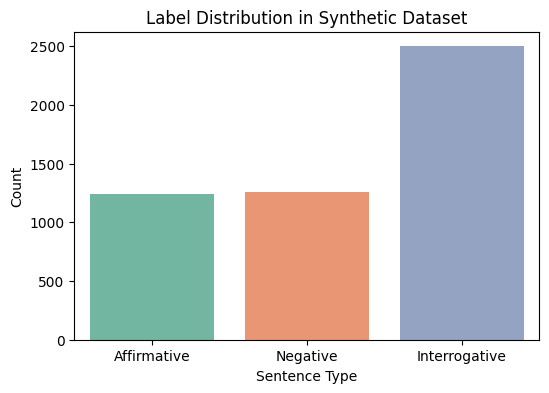

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(
    "/kaggle/working/NLP-Generator-v2/data/generated/sentences.csv"
)

label_map = {1: "Affirmative", 0: "Interrogative", -1: "Negative"}
df["label_name"] = df["label"].map(label_map)

df.head()

plt.figure(figsize=(6,4))

sns.countplot(
    data=df,
    x="label_name",
    hue="label_name",
    palette="Set2",
    legend=False
)

plt.title("Label Distribution in Synthetic Dataset")
plt.xlabel("Sentence Type")
plt.ylabel("Count")
plt.show()

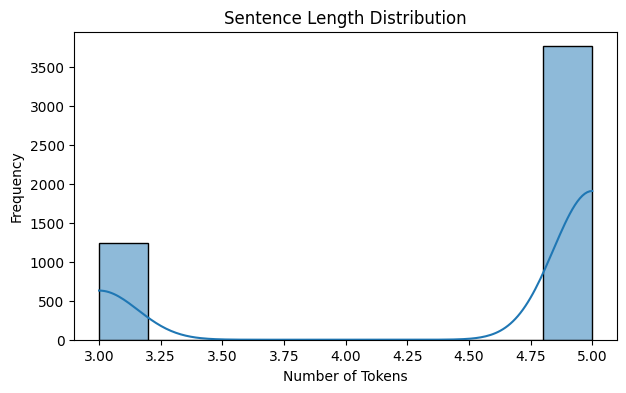

In [39]:
df["sentence_length"] = df["text"].str.split().apply(len)

plt.figure(figsize=(7,4))

sns.histplot(
    data=df,
    x="sentence_length",
    bins=10,
    kde=True
)

plt.title("Sentence Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

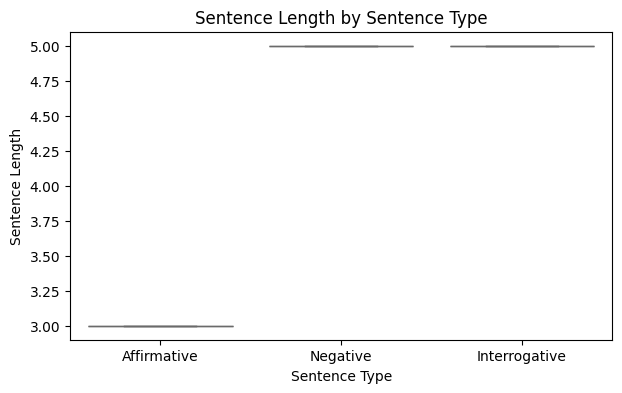

In [40]:
plt.figure(figsize=(7,4))

sns.boxplot(
    data=df,
    x="label_name",
    y="sentence_length",
    hue="label_name",
    palette="Set3",
    legend=False
)

plt.title("Sentence Length by Sentence Type")
plt.xlabel("Sentence Type")
plt.ylabel("Sentence Length")
plt.show()

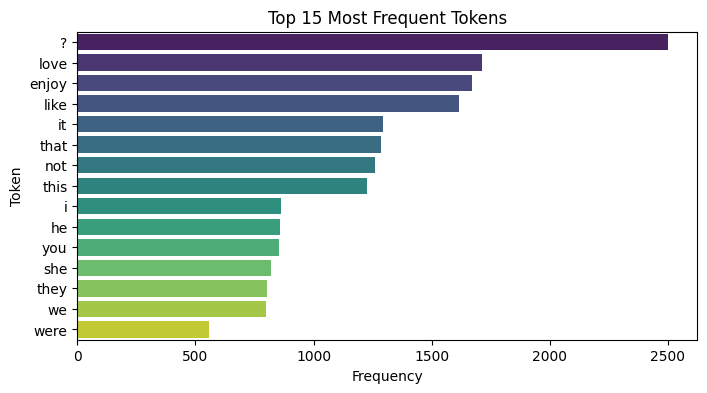

In [41]:
from collections import Counter

tokens = []
for s in df["text"]:
    tokens.extend(s.split())

token_freq = Counter(tokens)
top_tokens = token_freq.most_common(15)

token_df = pd.DataFrame(top_tokens, columns=["token", "count"])

plt.figure(figsize=(8,4))

sns.barplot(
    data=token_df,
    x="count",
    y="token",
    hue="token",
    palette="viridis",
    legend=False
)

plt.title("Top 15 Most Frequent Tokens")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()

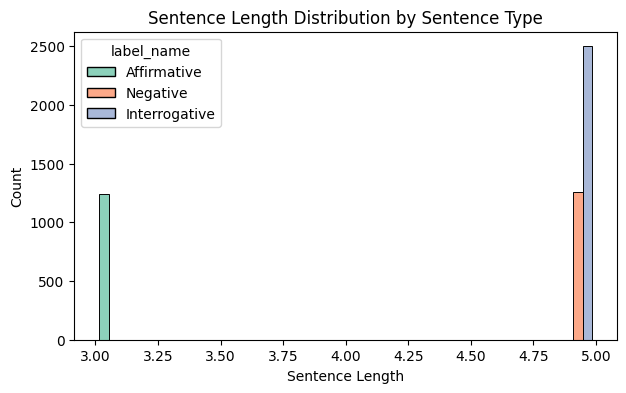

In [42]:
plt.figure(figsize=(7,4))

sns.histplot(
    data=df,
    x="sentence_length",
    hue="label_name",
    multiple="dodge",
    shrink=0.8,
    palette="Set2"
)

plt.title("Sentence Length Distribution by Sentence Type")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()